In [29]:
# !pip install kaggle
# !kaggle competitions download -c house-prices-advanced-regression-techniques

import zipfile

import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style='darkgrid')

# 1. Load in data

In [2]:
with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip') as zipf:
    zipf.printdir()
    zipf.extractall(path='data/')

File Name                                             Modified             Size
data_description.txt                           2019-12-15 21:33:36        13370
sample_submission.csv                          2019-12-15 21:33:36        31939
test.csv                                       2019-12-15 21:33:36       451405
train.csv                                      2019-12-15 21:33:36       460676


In [3]:
# read in training set and test set
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# peek through the training and test data
pd.concat([df_train.head(), df_test.head()])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


# 2. Inspect data

In [4]:
print(f"Shape of training set is {df_train.shape}")
print(f"Shape of test set is {df_test.shape}")

Shape of training set is (1460, 81)
Shape of test set is (1459, 80)


There are 1460 rows in the training set and 1459 rows in the test set.

The number of columns in both sets is the same. The one extra column in the training set is the target variable `SalePrice` that we are going to use to train our model.

The `Id` column is for identifying different houses. We suspect that it could be removed.

In [5]:
df_train['Id'].value_counts()

1       1
982     1
980     1
979     1
978     1
       ..
485     1
484     1
483     1
482     1
1460    1
Name: Id, Length: 1460, dtype: int64

Indeed it is. We can remove it from both training set and test set.

In [6]:
# define a function for easier removal of columns

def drop_col(cols):
    df_train.drop(cols, axis=1, inplace=True)
    df_test.drop(cols, axis=1, inplace=True)
    
# now remove Id
drop_col('Id')

## 2.1. Classify categorical features and numerical features

Categorical features and numerical features will be treated in different ways, hence we need to classify them.

In [7]:
df_test.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [8]:
num_cols, cat_cols = [], []

for col in df_test.columns:
    if df_test.dtypes[col] == object:
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
print("Numerical columns include:", num_cols)
print("Categorical columns include:", cat_cols)

Numerical columns include: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical columns include: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu'

## 2.2. Explore target variable `SalePrice`

In [9]:
# summary statistics of the target variable
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There seem to be some very large outliers that might affect the performance of the model.

<AxesSubplot:>

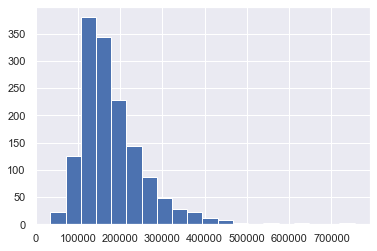

In [10]:
# distribution of the target variable
df_train['SalePrice'].hist(bins=20)

The distribution seems a bit skewed. Maybe a log- or sqrt- transformation is required.

In [11]:
# correlation with the feature variables
df_train.corr()['SalePrice'].reindex(df_train.corr()['SalePrice'].abs().sort_values(ascending=False).index)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

# 3. Missing values

In [12]:
# check missing values
print("Total number of missing values in the training set is:", df_train.isna().sum().sum())
print("Total number of missing values in the test set is:", df_test.isna().sum().sum())

Total number of missing values in the training set is: 6965
Total number of missing values in the test set is: 7000


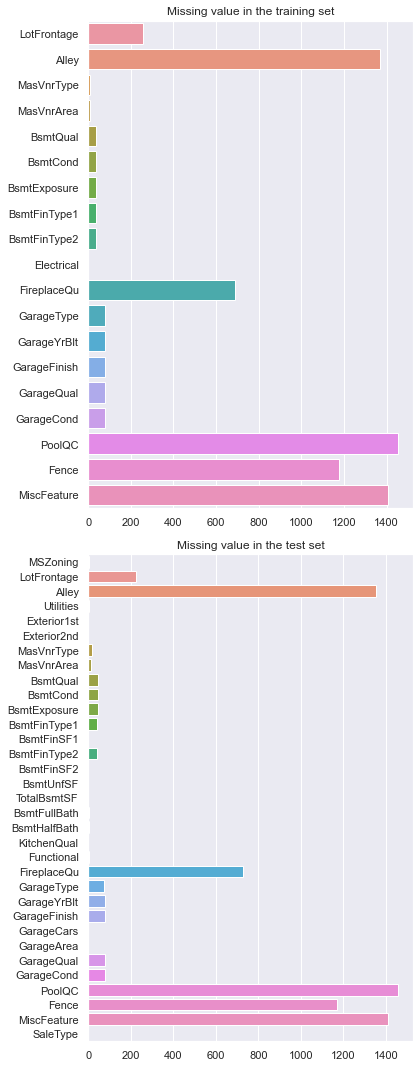

In [13]:
# the column-wise distribution of the missing values
plt.figure(figsize=(6,15))

na_col_train = df_train.columns[df_train.isna().sum() > 0].values
na_col_test = df_test.columns[df_test.isna().sum() > 0].values

plt.subplot(2,1,1)
sns.barplot(x=df_train.isna().sum()[na_col_train], y=na_col_train)
plt.title('Missing value in the training set')

plt.subplot(2,1,2)
sns.barplot(x=df_test.isna().sum()[na_col_test], y=na_col_test)
plt.title('Missing value in the test set')

plt.tight_layout()

## 3.1. Filling missing data according to descriptions

According to the data description file, 'NA' values in some features means 'No such utility'. For categorical features, what we can do is to add a new category (namely 'None') to represent those 'NA' value; for numerical features, replacing with zero is a good choice.

### Alley

For example, 'NA' value in `Alley` simply means no alley access of the property.

In [14]:
def fill_with(col, label):
    df_train[col] = df_train[col].fillna(label)
    df_test[col] = df_test[col].fillna(label)
    
fill_with('Alley', 'None')

### Mason veneer

In [19]:
fill_with('MasVnrType', 'None')

Mason veneer has two related features - type and area. If a property has no mason veneer (i.e. None type), we would also expect a zero area.

In [20]:
MasVnr_features = ['MasVnrType', 'MasVnrArea']
print(df_train.loc[df_train['MasVnrType'] == 'None', MasVnr_features].value_counts())
print(df_test.loc[df_test['MasVnrType'] == 'None', MasVnr_features].value_counts())

MasVnrType  MasVnrArea
None        0.0           859
            1.0             2
            288.0           1
            312.0           1
            344.0           1
dtype: int64
MasVnrType  MasVnrArea
None        0.0           876
            1.0             1
            198.0           1
            285.0           1
dtype: int64


Well, this is problematic, because a property with 'None' type mason veneer cannot possibly have an area. We can only assume that something went wrong during the data collection process.

However, at this stage, we must decide on how to deal with it. Since there are only few abnormal data points in the `MasVnrArea` feature, we will choose to stick with the type and set all mason veneer area variable to zero for 'None' type rows.

In [21]:
# set area to zero
df_train.loc[df_train['MasVnrType'] == 'None', 'MasVnrArea'] = 0
df_test.loc[df_test['MasVnrType'] == 'None', 'MasVnrArea'] = 0

### Basement

There are many basement-related features. In order to be consistent, a property with NA in any basement-related feature need to be labelled NA and zero in all basement-related features.

In [50]:
# list all basement-related feautures
Bsmt_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
Bsmt_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

# create hashmaps for storing na values count
hashmap_Bsmt_train, hashmap_Bsmt_test = defaultdict(int), defaultdict(int)

# iterate through all basement-related categorical features
for col in Bsmt_cat:
    # temporarily store index of rows containing na value for a given feature
    index_train = df_train[df_train[col].isna()].index.values
    index_test = df_test[df_test[col].isna()].index.values
    
    # add one to the counter
    for i in index_train:
        hashmap_Bsmt_train[i] += 1
    for i in index_test:
        hashmap_Bsmt_test[i] += 1

# if the count of na values for a given index is equal to 5, it means that
# all basement-related categorical features are consistent. 
# Else, the row of data is problematic.

# create list to store the problematic row indexes.
pi_Bsmt_train, pi_Bsmt_test = [], []

# iterate through the hashmap
for k, v in hashmap_Bsmt_train.items():
    # if the count is smaller than 5 add it to the list
    if v < 5:
        pi_Bsmt_train.append(k)
        
    # also count in the rows where the categorical features are consistent 
    # but the numerical features are problematic
    else:
        # if the sum of the numerical data is not zero
        if df_train.loc[k, Bsmt_num].sum():
            pi_Bsmt_train.append(k)

for k, v in hashmap_Bsmt_test.items():
    if v < 5:
        pi_Bsmt_test.append(k)
    else:
        if df_test.loc[k, Bsmt_num].sum():
            pi_Bsmt_test.append(k)


In [51]:
df_train.loc[pi_Bsmt_train, Bsmt_cat+Bsmt_num]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
948,Gd,TA,NaN,Unf,Unf,0,0,936,936
332,Gd,TA,No,GLQ,NaN,1124,479,1603,3206


In [52]:
df_test.loc[pi_Bsmt_test, Bsmt_cat+Bsmt_num]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
757,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0
758,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0
580,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0
725,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0
1064,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0
27,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0
888,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0


These missing values should be considered with caution. We can use summary statistics from other rows as reference.

In [65]:
# BsmtFinType2 should be related with BsmtFinSF2
df_train.groupby('BsmtFinType2')['BsmtFinSF2'].median()

BsmtFinType2
ALQ    606.0
BLQ    294.0
GLQ    623.0
LwQ    277.5
Rec    334.0
Unf      0.0
Name: BsmtFinSF2, dtype: float64

index 332 falls roughly into ALQ.

In [66]:
df_train.loc[332, 'BsmtFinType2'] = 'ALQ'

In [64]:
# BsmtQual
df_test.groupby('BsmtQual')[Bsmt_num].median()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
BsmtQual,,,,
Ex,1034.0,0.0,516.0,1612.0
Fa,0.0,0.0,455.0,684.0
Gd,426.0,0.0,455.0,1074.0
TA,303.0,0.0,481.5,930.5


Both index 757 and 758 fall into Fa.

In [67]:
df_test.loc[[757, 758], 'BsmtQual'] = 'Fa'

In [70]:
# BsmtCond
df_test.groupby('BsmtCond')[Bsmt_num].mean()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
BsmtCond,,,,
Fa,271.661017,19.101695,540.016949,830.779661
Gd,572.526316,100.578947,464.526316,1137.631579
Po,344.000000,0.000000,715.333333,1059.333333
TA,453.925097,53.650193,577.098842,1084.674131


index 580 and 725 fall into 'Gd', and index 1064 falls roughly into 'TA'

In [ ]:
# all the features that are going to have missing values filled with 'None' label.
fill_with_None = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                  'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
                  'GarageFinish', 'GarageQual', 'GarageQual', 'GarageCond',
                  'PoolQC', 'Fence', 'MiscFeature']

# fill the missing values
for col in fill_with_None:
    df_train[col] = df_train[col].fillna('None')
    df_test[col] = df_test[col].fillna('None')

## 3.2. Filling missing numerical feature data

From the experience of the previous section on categorical features, there are some missing numerical feature data that can be filled correspondingly.

For example, if a property has no basement (`Bsmy*` set to 'None'), then the corresponding numerical data (e.g. `TotalBsmtSF` - total square feet of basement area) should be zero.

This is true for alley, masonry veneer, basement, fireplace, garage, pool, fence and miscellaneous features.

### basement

In [ ]:
basement_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                     'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF']
print(len(df_train.loc[df_train['BsmtQual'] == 'None', basement_features].value_counts()))
print(len(df_test.loc[df_test['BsmtQual'] == 'None', basement_features].value_counts()))

The basement-related data in the test set is problematic.

In [ ]:
pd.DataFrame(df_test.loc[df_test['BsmtQual'] == 'None', basement_features].value_counts())

In [ ]:
df_train['BsmtQual'].value_counts()

In [ ]:
pd.DataFrame(df_test.loc[df_test['BsmtCond'] == 'None', basement_features].value_counts())